In [2]:
from monai.apps import download_and_extract
resource = "https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/MedNIST.tar.gz" # MNIST-like Data for the Medical Fields
md5 = "0bc7306e7427e00ad1c5526a6677552d"
root_dir = "./data"

download_and_extract(resource, root_dir, md5, file_type="tar.gz")

2025-05-24 14:40:12,059 - INFO - Expected md5 is None, skip md5 check for file data.
2025-05-24 14:40:12,060 - INFO - File exists: data, skipped downloading.
2025-05-24 14:40:12,061 - INFO - Writing into directory: 0bc7306e7427e00ad1c5526a6677552d.


##### MedNIST Image Classification Tutorial using MONAI engines

In [1]:
import os
import glob
from monai.transforms import Compose, LoadImaged, EnsureChannelFirstd, ScaleIntensityd, ToTensord # Data Preprocessing
from monai.data import CacheDataset, DataLoader # Data
from monai.networks.nets import DenseNet121 # NN
from torch.nn import CrossEntropyLoss # Loss
from monai.engines import SupervisedTrainer # Trainer (easy to use!)
from monai.handlers import StatsHandler, CheckpointSaver # Utils
import torch

c:\Users\emfor\Documents\Capstone\MONAI Tutorial\.venv\Lib\site-packages\ignite\handlers\checkpoint.py:17: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer
IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [ ]:
# Step 1: Data path
root_dir = "./data/0bc7306e7427e00ad1c5526a6677552d/MedNIST"
class_names = sorted(os.listdir(root_dir))
class_to_idx = {name: i for i, name in enumerate(class_names)}

# Step 2: Image + Label List
data_list = []
for class_name in class_names:
    image_paths = glob.glob(os.path.join(root_dir, class_name, "*.jpeg"))
    for img_path in image_paths:
        data_list.append({
            "image": img_path,
            "label": class_to_idx[class_name]
        })

# Step 3: Transform 
transforms = Compose([
    LoadImaged(keys=["image"]),
    EnsureChannelFirstd(keys=["image"]),
    ScaleIntensityd(keys=["image"]),
    ToTensord(keys=["image", "label"])
])

# Step 4: Dataset & DataLoader
dataset = CacheDataset(data=data_list, transform=transforms, cache_rate=1.0)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)



Loading dataset: 100%|██████████| 58954/58954 [01:58<00:00, 496.26it/s]


In [4]:
# Step 5: CNN based NN (with 6 classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenseNet121(spatial_dims=2, in_channels=1, out_channels=len(class_names)).to(device) # <-- CNN Based Image Classification NN Model predefined by MONAI

# Step 6: Loss + Optimizer
loss_function = CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Step 7: Trainer (from MONAI)
trainer = SupervisedTrainer(
    max_epochs=5,
    train_data_loader=train_loader,
    network=model,
    optimizer=optimizer,
    loss_function=loss_function,
    key_train_metric=None,
    train_handlers=[
        StatsHandler(tag_name="train_loss"),
    ],
    device=device
)

print(torch.cuda.is_available())  # GPU Usage Check
print(torch.cuda.get_device_name(0))
print(next(model.parameters()).device)

True
NVIDIA GeForce RTX 4060 Laptop GPU
cuda:0


In [5]:
# Step 8: Run!
trainer.run()

2025-05-24 16:06:44,086 - INFO - Epoch: 1/5, Iter: 1/922 -- label: 0.0000 loss: 1.9806 
2025-05-24 16:06:44,204 - INFO - Epoch: 1/5, Iter: 2/922 -- label: 1.0000 loss: 1.7616 


ignoring non-scalar output in StatsHandler, make sure `output_transform(engine.state.output)` returns a scalar or dictionary of key and scalar pairs to avoid this warning. image:<class 'monai.data.meta_tensor.MetaTensor'>
ignoring non-scalar output in StatsHandler, make sure `output_transform(engine.state.output)` returns a scalar or dictionary of key and scalar pairs to avoid this warning. pred:<class 'monai.data.meta_tensor.MetaTensor'>


2025-05-24 16:06:44,308 - INFO - Epoch: 1/5, Iter: 3/922 -- label: 0.0000 loss: 1.6960 
2025-05-24 16:06:44,418 - INFO - Epoch: 1/5, Iter: 4/922 -- label: 1.0000 loss: 1.5883 
2025-05-24 16:06:44,530 - INFO - Epoch: 1/5, Iter: 5/922 -- label: 4.0000 loss: 1.3873 
2025-05-24 16:06:44,628 - INFO - Epoch: 1/5, Iter: 6/922 -- label: 2.0000 loss: 1.1034 
2025-05-24 16:06:44,729 - INFO - Epoch: 1/5, Iter: 7/922 -- label: 4.0000 loss: 1.1359 
2025-05-24 16:06:44,858 - INFO - Epoch: 1/5, Iter: 8/922 -- label: 4.0000 loss: 0.9592 
2025-05-24 16:06:44,975 - INFO - Epoch: 1/5, Iter: 9/922 -- label: 2.0000 loss: 0.8321 
2025-05-24 16:06:45,083 - INFO - Epoch: 1/5, Iter: 10/922 -- label: 0.0000 loss: 0.7443 
2025-05-24 16:06:45,194 - INFO - Epoch: 1/5, Iter: 11/922 -- label: 2.0000 loss: 0.7249 
2025-05-24 16:06:45,297 - INFO - Epoch: 1/5, Iter: 12/922 -- label: 2.0000 loss: 0.6657 
2025-05-24 16:06:45,397 - INFO - Epoch: 1/5, Iter: 13/922 -- label: 4.0000 loss: 0.5914 
2025-05-24 16:06:45,499 - IN

In [10]:
from monai.engines import SupervisedEvaluator
from ignite.metrics import Accuracy

In [ ]:
def custom_iteration_update(engine, batch):
    inputs, labels = batch["image"].to(device), batch["label"].to(device)
    outputs = model(inputs)
    return outputs, labels 

evaluator = SupervisedEvaluator(
    device=device,
    val_data_loader=train_loader,
    network=model,
    prepare_batch=None,  
    iteration_update=custom_iteration_update,
    key_val_metric={
        "accuracy": Accuracy(output_transform=lambda x: x)
    },
    val_handlers=[StatsHandler(tag_name="val_eval")]
)

evaluator.run()

ignoring non-scalar output in StatsHandler, make sure `output_transform(engine.state.output)` returns a scalar or a dictionary of key and scalar pairs to avoid this warning. <class 'monai.data.meta_tensor.MetaTensor'>


2025-05-24 16:34:12,616 - INFO - Epoch[1] Metrics -- accuracy: 0.9991 
2025-05-24 16:34:12,617 - INFO - Key metric: accuracy best value: 0.999134918750212 at epoch: 1


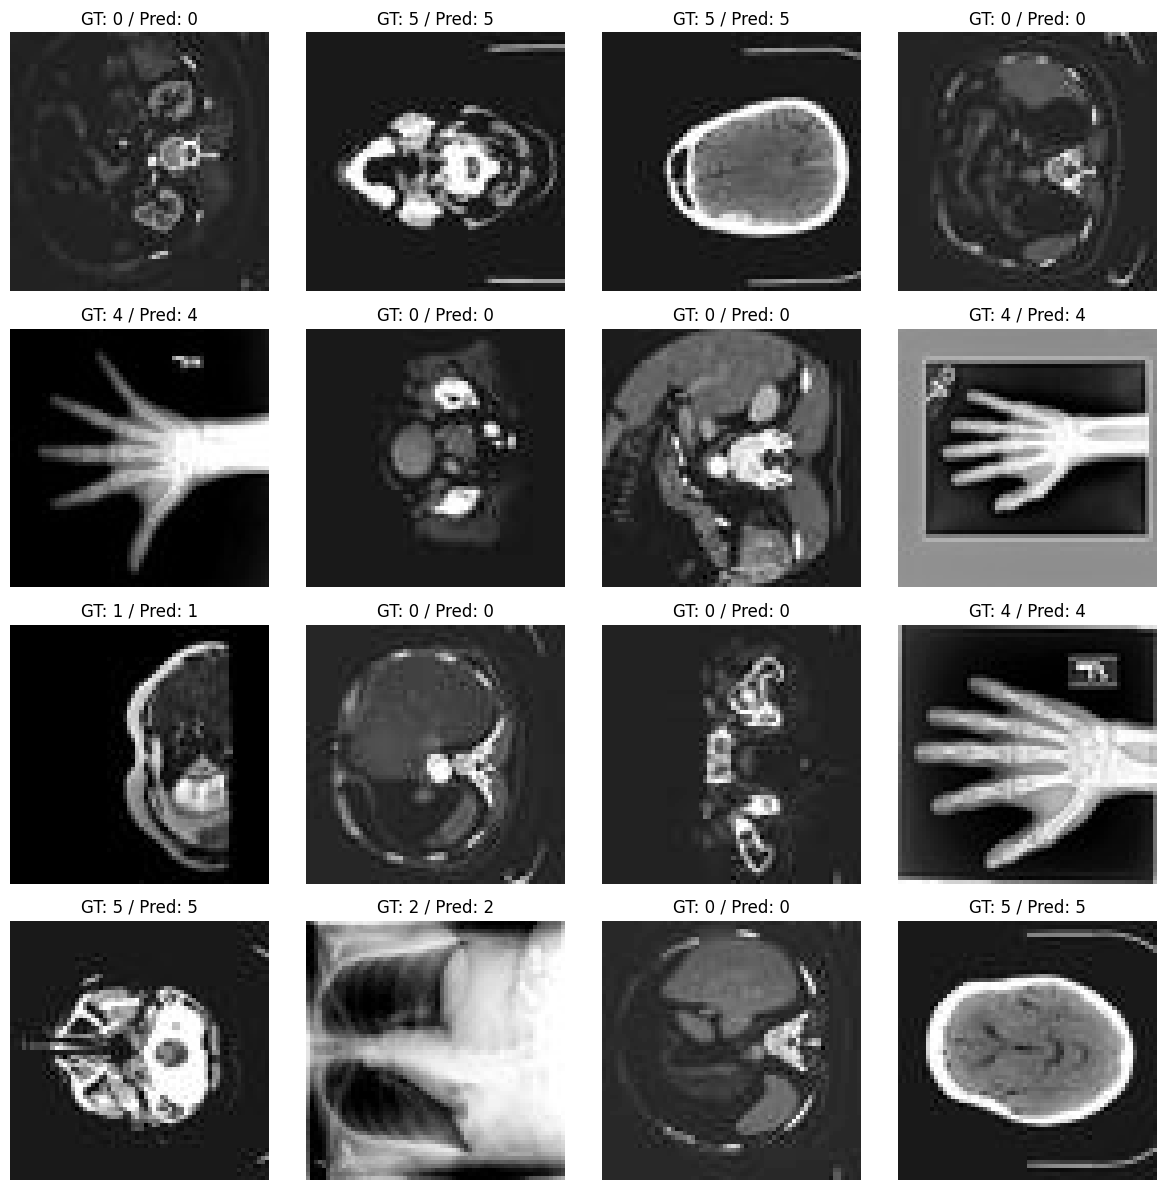

In [ ]:
import matplotlib.pyplot as plt

# pick a batch from the train_loader (you can replace this with val_loader later)
model.eval()
with torch.no_grad():
    for batch in train_loader:
        images = batch["image"].to(device)
        labels = batch["label"].to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        break  # only show one batch

# Convert to CPU and numpy
images_np = images.cpu().numpy()
labels_np = labels.cpu().numpy()
preds_np = preds.cpu().numpy()

# Plot in a 4x4 grid
n = min(16, len(images_np))
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
for i, ax in enumerate(axes.flat):
    if i >= n:
        ax.axis("off")
        continue
    img = images_np[i][0]  # channel-first (1, H, W) -> (H, W)
    ax.imshow(img, cmap="gray")
    ax.set_title(f"GT: {labels_np[i]} / Pred: {preds_np[i]}")
    ax.axis("off")

plt.tight_layout()
plt.show()
